<a href="https://colab.research.google.com/github/ipejun-ai/m5-accuracy/blob/master/m5_three_shades_of_dark_darker_magic_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
DIRPATH="/content/gdrive/My Drive/kaggle/m5-forecasting-accuracy/"
#DIRPATH="C:/Users/peiju/Documents/Study/kaggle/m5-forecasting-accuracy/"

In [0]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [0]:
#nolimittation of store
def get_data():
   # Read and contact basic feature
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)
    
    # Leave only relevant store
    #df = df[df['store_id']==store]

    # With memory limits we have to read 
    # lags and mean encoding features
    # separately and drop items that we don't need.
    # As our Features Grids are aligned 
    # we can use index to keep only necessary rows
    # Alignment is good for us as concat uses less memory than merge.
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]


    df4 = pd.read_pickle(SNAP).iloc[:,2:]
    df4 = df4[df4.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 # to not reach memory limit 
    
    df = pd.concat([df, df3], axis=1)
    del df3 # to not reach memory limit 

    df = pd.concat([df, df4], axis=1)
    del df4 # to not reach memory limit 

   

    
    # Create features list
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d',TARGET]+features]
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    return df, features


In [0]:
########################### Helper to load data by store ID
#################################################################################
# Read data
def get_data_by_store(store):
    
    # Read and contact basic feature
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)
    
    # Leave only relevant store
    df = df[df['store_id']==store]

    # With memory limits we have to read 
    # lags and mean encoding features
    # separately and drop items that we don't need.
    # As our Features Grids are aligned 
    # we can use index to keep only necessary rows
    # Alignment is good for us as concat uses less memory than merge.
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]


    df4 = pd.read_pickle(SNAP).iloc[:,2:]
    df4 = df4[df4.index.isin(df.index)]

    #df5 = pd.read_pickle(EVENT_TYPE).iloc[:,2:]
    #df5 = df5[df5.index.isin(df.index)]

    df6 = pd.read_pickle(EVENT_VALUE).iloc[:,2]
    df6 = df6[df6.index.isin(df.index)]

    df7 = pd.read_pickle(LAGS_364).iloc[:,2:]
    df7 = df7[df7.index.isin(df.index)]

    df8 = pd.read_pickle(HOLIDAY).iloc[:,2:]
    df8 = df8[df8.index.isin(df.index)]

    #df5 = pd.read_pickle(EVENT_TYPE).iloc[:,2:]
    #df5 = df5[df5.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 # to not reach memory limit 
    
    df = pd.concat([df, df3], axis=1)
    del df3 # to not reach memory limit 

    df = pd.concat([df, df4], axis=1)
    del df4 # to not reach memory limit 

    #df = pd.concat([df, df5], axis=1)
    #del df5 # to not reach memory limit 

    df = pd.concat([df, df6], axis=1)
    del df6 # to not reach memory limit 

    df = pd.concat([df, df7], axis=1)
    del df7 # to not reach memory limit 

    df = pd.concat([df, df8], axis=1)
    del df8 # to not reach memory limit  

   

    
    # Create features list
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d',TARGET]+features]
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    return df, features

# Recombine Test set after training
def get_base_test():
    base_test = pd.DataFrame()

    for store_id in STORES_IDS:
        temp_df = pd.read_pickle('test_'+store_id+'.pkl')
        temp_df['store_id'] = store_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
    return base_test


########################### Helper to make dynamic rolling lags
#################################################################################
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [0]:
########################### Model params
#################################################################################
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

# Let's look closer on params

## 'boosting_type': 'gbdt'
# we have 'goss' option for faster training
# but it normally leads to underfit.
# Also there is good 'dart' mode
# but it takes forever to train
# and model performance depends 
# a lot on random factor 
# https://www.kaggle.com/c/home-credit-default-risk/discussion/60921

## 'objective': 'tweedie'
# Tweedie Gradient Boosting for Extremely
# Unbalanced Zero-inflated Data
# https://arxiv.org/pdf/1811.10192.pdf
# and many more articles about tweediie
#
# Strange (for me) but Tweedie is close in results
# to my own ugly loss.
# My advice here - make OWN LOSS function
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/140564
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# I think many of you already using it (after poisson kernel appeared) 
# (kagglers are very good with "params" testing and tuning).
# Try to figure out why Tweedie works.
# probably it will show you new features options
# or data transformation (Target transformation?).

## 'tweedie_variance_power': 1.1
# default = 1.5
# set this closer to 2 to shift towards a Gamma distribution
# set this closer to 1 to shift towards a Poisson distribution
# my CV shows 1.1 is optimal 
# but you can make your own choice

## 'metric': 'rmse'
# Doesn't mean anything to us
# as competition metric is different
# and we don't use early stoppings here.
# So rmse serves just for general 
# model performance overview.
# Also we use "fake" validation set
# (as it makes part of the training set)
# so even general rmse score doesn't mean anything))
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

## 'subsample': 0.5
# Serves to fight with overfit
# this will randomly select part of data without resampling
# Chosen by CV (my CV can be wrong!)
# Next kernel will be about CV

##'subsample_freq': 1
# frequency for bagging
# default value - seems ok

## 'learning_rate': 0.03
# Chosen by CV
# Smaller - longer training
# but there is an option to stop 
# in "local minimum"
# Bigger - faster training
# but there is a chance to
# not find "global minimum" minimum

## 'num_leaves': 2**11-1
## 'min_data_in_leaf': 2**12-1
# Force model to use more features
# We need it to reduce "recursive"
# error impact.
# Also it leads to overfit
# that's why we use small 
# 'max_bin': 100

## l1, l2 regularizations
# https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
# Good tiny explanation
# l2 can work with bigger num_leaves
# but my CV doesn't show boost
                    
## 'n_estimators': 1400
# CV shows that there should be
# different values for each state/store.
# Current value was chosen 
# for general purpose.
# As we don't use any early stopings
# careful to not overfit Public LB.

##'feature_fraction': 0.5
# LightGBM will randomly select 
# part of features on each iteration (tree).
# We have maaaany features
# and many of them are "duplicates"
# and many just "noise"
# good values here - 0.5-0.7 (by CV)

## 'boost_from_average': False
# There is some "problem"
# to code boost_from_average for 
# custom loss
# 'True' makes training faster
# BUT carefull use it
# https://github.com/microsoft/LightGBM/issues/1514
# not our case but good to know cons

# Vars & Path

In [0]:
########################### Vars
#################################################################################
VER = 18                          # Our model version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores


#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913              # End day of our train set
P_HORIZON   = 28                 # Prediction horizon
USE_AUX     = False        # Use or not pretrained models
USE_PKL     = False

#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_features = ['id','state_id'
                    #,'store_id',
                   'date','wm_yr_wk','d','snap_CA','snap_TX','snap_WI'
                   ,"event_name_1",
                   "event_type_1","event_name_2","event_type_2",
                   TARGET]
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

##selected feature by boruta
"""
selected_feature=['item_id', 'dept_id', 'release', 'sell_price', 'price_max', 'price_min',
       'price_std', 'price_mean', 'price_norm', 'item_nunique',
       'price_momentum_m', 'price_momentum_y', 'event_type_1', 'tm_d', 'tm_w',
       'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'enc_dept_id_mean',
       'enc_dept_id_std', 'enc_item_id_mean', 'enc_item_id_std',
       'sales_lag_28', 'sales_lag_35', 'rolling_mean_7', 'rolling_std_7',
       'rolling_mean_14', 'rolling_std_14', 'rolling_mean_30',
       'rolling_std_30', 'rolling_mean_60', 'rolling_std_60',
       'rolling_mean_180', 'rolling_std_180', 'rolling_mean_tmp_1_7',
       'rolling_mean_tmp_1_14', 'rolling_mean_tmp_1_30',
       'rolling_mean_tmp_1_60', 'rolling_mean_tmp_7_7',
       'rolling_mean_tmp_7_14', 'rolling_mean_tmp_7_30',
       'rolling_mean_tmp_7_60', 'rolling_mean_tmp_14_7',
       'rolling_mean_tmp_14_14', 'rolling_mean_tmp_14_30',
       'rolling_mean_tmp_14_60', 'snap', 'Event_total',
       'sales_lag_28_364', 'rolling_mean_7_364',
       'rolling_std_7_364', 'rolling_mean_14_364', 'rolling_std_14_364',
       'rolling_mean_30_364', 'rolling_std_30_364', 'holiday',
       'rolling_holiday_mean_7', 'rolling_holiday_mean_14',
       'rolling_holiday_mean_30', 'rolling_holiday_mean_60',
       'rolling_holiday_mean_180']
"""

#PATHS for Features
ORIGINAL = DIRPATH
BASE     = DIRPATH+'/output/m5-simple-fe/grid_part_1.pkl'
PRICE    = DIRPATH+'/output/m5-simple-fe/grid_part_2.pkl'
CALENDAR = DIRPATH+'/output/m5-simple-fe/grid_part_3.pkl'
LAGS     = DIRPATH+'/output/m5-lags-features/lags_df_28.pkl'
MEAN_ENC = DIRPATH+'/output/m5-custom-features/mean_encoding_df.pkl'
FINAL_SALES = DIRPATH+'/output/m5-custom-features/finalsales_df.pkl'
SNAP      =  DIRPATH+'/output/m5-custom-features/snap_df.pkl'
EVENT_TYPE      =  DIRPATH+'/output/m5-custom-features/event_type.pkl'
EVENT_VALUE      =  DIRPATH+'/output/m5-custom-features/event_value.pkl'
LAGS_364=  DIRPATH+'/output/m5-custom-features/lags_df_364.pkl'
HOLIDAY=DIRPATH+'/output/m5-custom-features/holiday_mean.pkl'


#PATHS for Features
"""
ORIGINAL = DIRPATH
BASE     = DIRPATH+'/pickle/grid_part_1.pkl'
PRICE    = DIRPATH+'/pickle/grid_part_2.pkl'
CALENDAR = DIRPATH+'/pickle/grid_part_3.pkl'
LAGS     = DIRPATH+'//pickle//lags_df_28.pkl'
MEAN_ENC = DIRPATH+'//pickle//mean_encoding_df.pkl'
FINAL_SALES = DIRPATH+'//pickle//finalsales_df.pkl'
SNAP      =  DIRPATH+'//pickle//snap_df.pkl'
EVENT_TYPE      =  DIRPATH+'//pickle//event_type.pkl'
EVENT_VALUE      =  DIRPATH+'//pickle//event_value.pkl'
LAGS_364=  DIRPATH+'//pickle//lags_df_364.pkl'
HOLIDAY=DIRPATH+'//pickle//holiday_mean.pkl'
"""
# AUX(pretrained) Models paths
AUX_MODELS = DIRPATH+'/output/m5-three-shades-of-dark-darker-magic_tune/'

SAVE_DIR = DIRPATH+'/output/m5-three-shades-of-dark-darker-magic_tune/'


#STORES ids
STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_validation.csv')['store_id']
STORES_IDS = list(STORES_IDS.unique())


#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])

In [0]:
########################### Aux Models
# If you don't want to wait hours and hours
# to have result you can train each store 
# in separate kernel and then just join result.

# If we want to use pretrained models we can 
## skip training 
## (in our case do dummy training
##  to show that we are good with memory
##  and you can safely use this (all kernel) code)
if USE_AUX:
    lgb_params['n_estimators'] = 2
    
# Here is some 'logs' that can compare
#Train CA_1
#[100]	valid_0's rmse: 2.02289
#[200]	valid_0's rmse: 2.0017
#[300]	valid_0's rmse: 1.99239
#[400]	valid_0's rmse: 1.98471
#[500]	valid_0's rmse: 1.97923
#[600]	valid_0's rmse: 1.97284
#[700]	valid_0's rmse: 1.96763
#[800]	valid_0's rmse: 1.9624
#[900]	valid_0's rmse: 1.95673
#[1000]	valid_0's rmse: 1.95201
#[1100]	valid_0's rmse: 1.9476
#[1200]	valid_0's rmse: 1.9434
#[1300]	valid_0's rmse: 1.9392
#[1400]	valid_0's rmse: 1.93446

#Train CA_2
#[100]	valid_0's rmse: 1.88949
#[200]	valid_0's rmse: 1.84767
#[300]	valid_0's rmse: 1.83653
#[400]	valid_0's rmse: 1.82909
#[500]	valid_0's rmse: 1.82265
#[600]	valid_0's rmse: 1.81725
#[700]	valid_0's rmse: 1.81252
#[800]	valid_0's rmse: 1.80736
#[900]	valid_0's rmse: 1.80242
#[1000]	valid_0's rmse: 1.79821
#[1100]	valid_0's rmse: 1.794
#[1200]	valid_0's rmse: 1.78973
#[1300]	valid_0's rmse: 1.78552
#[1400]	valid_0's rmse: 1.78158

In [0]:
if USE_PKL:
  grid_df_all=pd.read_pickle(AUX_MODELS+'grid_df_all_v'+str(VER)+'.pkl') 
  features=pd.read_csv(AUX_MODELS+'feature_v'+str(VER)+'.csv',header=None)
  features_columns=list(features[0])
else:
  grid_df_all, features_columns = get_data()
  grid_df_all.to_pickle(AUX_MODELS+'grid_df_all_v'+str(VER)+'.pkl')
  imp=pd.DataFrame({'feature': features_columns})
  imp.to_csv(AUX_MODELS+'feature_v'+str(VER)+'.csv', index=False)

In [0]:
features_columns.remove("store_id")

# Parameter tuning

In [13]:
!pip install optuna

     |████████████████████████████████| 184kB 1.7MB/s 
     |████████████████████████████████| 1.1MB 10.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 81kB 9.1MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 112kB 12.6MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=9cf3d5969530e18fe5982669d9af8e00a0eeef1f40fc5679ebf42e0f97ec0ff8
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.4.0-cp36-none-any.whl size=254554 sha256=e24a39fd6992509f2b0660f13265a130e83321d478031bf80c6fdde20e1f11b2
  Stored in directory: /root/.cache/pip/wheels/3e/4

In [0]:
import optuna.integration.lightgbm as lgb_o

In [0]:
param_defaults = {
    'metric': 'rmse',
    'objective':'tweedie',
    'lambda_l1': 0.0,
    'lambda_l2': 0.0,
    'num_leaves': 2**11-1,
    'feature_fraction':  0.5,
    'bagging_fraction':  1.0,
    'bagging_freq': 0,
    'min_child_samples': 20
}

In [16]:
########################### Train Models
#################################################################################
for store_id in STORES_IDS:
#for store_id in ["CA_1"]:
    print('Train', store_id)
    
    # Get grid for current store
    #grid_df, features_columns = get_data_by_store(store_id)
    grid_df=grid_df_all[grid_df_all['store_id']==store_id]
    grid_df=grid_df.drop("store_id",axis=1)
    ##borutaで選択した特徴量に変換
    #features_columns=[x for x in features_columns if x in selected_feature]
    
    # Masks for 
    # Train (All data less than 1913)
    # "Validation" (Last 28 days - not real validatio set)
    # Test (All data greater than 1913 day, 
    #       with some gap for recursive features)
    train_mask = grid_df['d']<=END_TRAIN
    #valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
    #last year
    valid_mask = train_mask&(grid_df['d']>(END_TRAIN-364))&(grid_df['d']<=(END_TRAIN-364+P_HORIZON))
    #real validation
    #valid_mask = (grid_df['d']<=(END_TRAIN+P_HORIZON))&(grid_df['d']>(END_TRAIN))
    preds_mask = grid_df['d']>(END_TRAIN-100)
    
    # Apply masks and save lgb dataset as bin
    # to reduce memory spikes during dtype convertations
    # https://github.com/Microsoft/LightGBM/issues/1032
    # "To avoid any conversions, you should always use np.float32"
    # or save to bin before start training
    # https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
    train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
                       label=grid_df[train_mask][TARGET])
    train_data.save_binary('train_data.bin')
    train_data = lgb.Dataset('train_data.bin')
    
    valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                       label=grid_df[valid_mask][TARGET])
    
    # Saving part of the dataset for later predictions
    # Removing features that we need to calculate recursively 
    grid_df = grid_df[preds_mask].reset_index(drop=True)
    keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
    grid_df = grid_df[keep_cols]
    grid_df.to_pickle('test_'+store_id+'.pkl')
    del grid_df
    

    if USE_AUX==False:
      # Launch seeder again to make lgb training 100% deterministic
      # with each "code line" np.random "evolves" 
      # so we need (may want) to "reset" it
      seed_everything(SEED)
      
      print("start tuning")
      params = {
      'objective':  'tweedie',
      'metric': 'rmse'
      }
      best_params, history = {}, []
      model = lgb_o.train(params,
                        train_data,
                        valid_sets = [valid_data],
                        verbose_eval=False,
                        num_boost_round=10,
                        early_stopping_rounds=5,
                        best_params=best_params,
                        tuning_history=history)
      
      #best_paramsでパラメーターを更新
      lgb_params.update(best_params)
      print(best_params)
      print("start modeling")
      estimator = lgb.train(lgb_params,
                            train_data,
                            valid_sets = [valid_data],
                            verbose_eval = 100,
                            )

    

    
    # Save model - it's not real '.bin' but a pickle file
    # estimator = lgb.Booster(model_file='model.txt')
    # can only predict with the best iteration (or the saving iteration)
    # pickle.dump gives us more flexibility
    # like estimator.predict(TEST, num_iteration=100)
    # num_iteration - number of iteration want to predict with, 
    # NULL or <= 0 means use best iteration
    if USE_AUX==False:
      model_name = AUX_MODELS+'lgb_model_'+store_id+'_v'+str(VER)+'.bin'
      pickle.dump(estimator, open(model_name, 'wb'))
    else:
      estimator=""

    # Remove temporary files and objects 
    # to free some hdd space and ram memory
    !rm train_data.bin
    del train_data, valid_data, estimator
    gc.collect()
    
    # "Keep" models features for predictions
    MODEL_FEATURES = features_columns

Train CA_1


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

start tuning


min_data_in_leaf, val_score: 3.059461: 100%|##########| 5/5 [00:27<00:00,  5.46s/it]


{'lambda_l1': 0.15182130181952871, 'lambda_l2': 0.004611802479071805, 'num_leaves': 256, 'feature_fraction': 0.852, 'bagging_fraction': 0.7435697461695239, 'bagging_freq': 5, 'min_child_samples': 20, 'objective': 'tweedie', 'metric': 'rmse'}
start modeling
[100]	valid_0's rmse: 2.06672
[200]	valid_0's rmse: 2.02826
[300]	valid_0's rmse: 2.01355
[400]	valid_0's rmse: 2.00201
[500]	valid_0's rmse: 1.99172
[600]	valid_0's rmse: 1.98426
[700]	valid_0's rmse: 1.97587
[800]	valid_0's rmse: 1.96835
[900]	valid_0's rmse: 1.96177
[1000]	valid_0's rmse: 1.95602
[1100]	valid_0's rmse: 1.95014
[1200]	valid_0's rmse: 1.94426
[1300]	valid_0's rmse: 1.9385
[1400]	valid_0's rmse: 1.93335
Train CA_2


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

start tuning


min_data_in_leaf, val_score: 1.774169: 100%|##########| 5/5 [00:27<00:00,  5.47s/it]


{'lambda_l1': 4.490970139484783e-06, 'lambda_l2': 0.21127669161049475, 'num_leaves': 252, 'feature_fraction': 0.748, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 25, 'objective': 'tweedie', 'metric': 'rmse'}
start modeling
[100]	valid_0's rmse: 1.54455
[200]	valid_0's rmse: 1.52884
[300]	valid_0's rmse: 1.51894
[400]	valid_0's rmse: 1.51059
[500]	valid_0's rmse: 1.50393
[600]	valid_0's rmse: 1.49877
[700]	valid_0's rmse: 1.49378
[800]	valid_0's rmse: 1.48972
[900]	valid_0's rmse: 1.48521
[1000]	valid_0's rmse: 1.48001
[1100]	valid_0's rmse: 1.47511
[1200]	valid_0's rmse: 1.47053
[1300]	valid_0's rmse: 1.46623
[1400]	valid_0's rmse: 1.46247
Train CA_3


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

start tuning


min_data_in_leaf, val_score: 4.162737: 100%|##########| 5/5 [00:37<00:00,  7.43s/it]


{'lambda_l1': 0.011521182771876996, 'lambda_l2': 0.0155931906547309, 'num_leaves': 255, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.9572876129816752, 'bagging_freq': 4, 'min_child_samples': 20, 'objective': 'tweedie', 'metric': 'rmse'}
start modeling
[100]	valid_0's rmse: 2.72803
[200]	valid_0's rmse: 2.65947
[300]	valid_0's rmse: 2.62096
[400]	valid_0's rmse: 2.59888
[500]	valid_0's rmse: 2.58454
[600]	valid_0's rmse: 2.56969
[700]	valid_0's rmse: 2.55774
[800]	valid_0's rmse: 2.54694
[900]	valid_0's rmse: 2.53688
[1000]	valid_0's rmse: 2.52764
[1100]	valid_0's rmse: 2.51862
[1200]	valid_0's rmse: 2.51086
[1300]	valid_0's rmse: 2.50201
[1400]	valid_0's rmse: 2.49677
Train CA_4


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

start tuning


min_data_in_leaf, val_score: 1.605491: 100%|##########| 5/5 [00:24<00:00,  4.90s/it]


{'lambda_l1': 7.303143965694442e-05, 'lambda_l2': 1.8519937256199617e-08, 'num_leaves': 256, 'feature_fraction': 0.9159999999999999, 'bagging_fraction': 0.665409050803164, 'bagging_freq': 4, 'min_child_samples': 5, 'objective': 'tweedie', 'metric': 'rmse'}
start modeling
[100]	valid_0's rmse: 1.38464
[200]	valid_0's rmse: 1.37081
[300]	valid_0's rmse: 1.36308
[400]	valid_0's rmse: 1.35752
[500]	valid_0's rmse: 1.35232
[600]	valid_0's rmse: 1.34817
[700]	valid_0's rmse: 1.34398
[800]	valid_0's rmse: 1.33995
[900]	valid_0's rmse: 1.33623
[1000]	valid_0's rmse: 1.3324
[1100]	valid_0's rmse: 1.32866
[1200]	valid_0's rmse: 1.32478
[1300]	valid_0's rmse: 1.32155
[1400]	valid_0's rmse: 1.31757
Train TX_1


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

start tuning


min_data_in_leaf, val_score: 2.378536: 100%|##########| 5/5 [00:32<00:00,  6.57s/it]


{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 251, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 0.7307117146809439, 'bagging_freq': 1, 'min_child_samples': 10, 'objective': 'tweedie', 'metric': 'rmse'}
start modeling
[100]	valid_0's rmse: 1.75744
[200]	valid_0's rmse: 1.75096
[300]	valid_0's rmse: 1.73261
[400]	valid_0's rmse: 1.71744
[500]	valid_0's rmse: 1.70433
[600]	valid_0's rmse: 1.69189
[700]	valid_0's rmse: 1.6813
[800]	valid_0's rmse: 1.67033
[900]	valid_0's rmse: 1.65672
[1000]	valid_0's rmse: 1.64461
[1100]	valid_0's rmse: 1.63208
[1200]	valid_0's rmse: 1.62003
[1300]	valid_0's rmse: 1.60925
[1400]	valid_0's rmse: 1.59461
Train TX_2


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

start tuning


min_data_in_leaf, val_score: 2.916358: 100%|##########| 5/5 [00:22<00:00,  4.44s/it]


{'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 256, 'feature_fraction': 0.88, 'bagging_fraction': 0.5650505762667344, 'bagging_freq': 3, 'min_child_samples': 20, 'objective': 'tweedie', 'metric': 'rmse'}
start modeling
[100]	valid_0's rmse: 1.89972
[200]	valid_0's rmse: 1.86983
[300]	valid_0's rmse: 1.85389
[400]	valid_0's rmse: 1.84421
[500]	valid_0's rmse: 1.83611
[600]	valid_0's rmse: 1.82976
[700]	valid_0's rmse: 1.82241
[800]	valid_0's rmse: 1.81665
[900]	valid_0's rmse: 1.81147
[1000]	valid_0's rmse: 1.80687
[1100]	valid_0's rmse: 1.8027
[1200]	valid_0's rmse: 1.79678
[1300]	valid_0's rmse: 1.79216
[1400]	valid_0's rmse: 1.78852
Train TX_3


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

start tuning


min_data_in_leaf, val_score: 3.302369: 100%|##########| 5/5 [00:19<00:00,  3.85s/it]


{'lambda_l1': 1.0003848696994042e-08, 'lambda_l2': 8.017945333381376e-08, 'num_leaves': 255, 'feature_fraction': 0.948, 'bagging_fraction': 0.472161643327404, 'bagging_freq': 6, 'min_child_samples': 20, 'objective': 'tweedie', 'metric': 'rmse'}
start modeling
[100]	valid_0's rmse: 1.98243
[200]	valid_0's rmse: 1.93821
[300]	valid_0's rmse: 1.92435
[400]	valid_0's rmse: 1.91469
[500]	valid_0's rmse: 1.90691
[600]	valid_0's rmse: 1.89923
[700]	valid_0's rmse: 1.89373
[800]	valid_0's rmse: 1.88616
[900]	valid_0's rmse: 1.87978
[1000]	valid_0's rmse: 1.87411
[1100]	valid_0's rmse: 1.86934
[1200]	valid_0's rmse: 1.86525
[1300]	valid_0's rmse: 1.86122
[1400]	valid_0's rmse: 1.85583
Train WI_1


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

start tuning


min_data_in_leaf, val_score: 1.974456: 100%|##########| 5/5 [00:32<00:00,  6.54s/it]


{'lambda_l1': 0.07525838206183809, 'lambda_l2': 0.02239241556461298, 'num_leaves': 254, 'feature_fraction': 0.88, 'bagging_fraction': 0.9445980245636441, 'bagging_freq': 1, 'min_child_samples': 100, 'objective': 'tweedie', 'metric': 'rmse'}
start modeling
[100]	valid_0's rmse: 1.54799
[200]	valid_0's rmse: 1.52648
[300]	valid_0's rmse: 1.51754
[400]	valid_0's rmse: 1.51128
[500]	valid_0's rmse: 1.50602
[600]	valid_0's rmse: 1.50204
[700]	valid_0's rmse: 1.49872
[800]	valid_0's rmse: 1.4947
[900]	valid_0's rmse: 1.49146
[1000]	valid_0's rmse: 1.48847
[1100]	valid_0's rmse: 1.48445
[1200]	valid_0's rmse: 1.48162
[1300]	valid_0's rmse: 1.47891
[1400]	valid_0's rmse: 1.47658
Train WI_2


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

start tuning


min_data_in_leaf, val_score: 3.072128: 100%|##########| 5/5 [00:28<00:00,  5.80s/it]


{'lambda_l1': 2.7179189357179463, 'lambda_l2': 1.866363219121882e-07, 'num_leaves': 255, 'feature_fraction': 0.88, 'bagging_fraction': 0.8116454586140662, 'bagging_freq': 6, 'min_child_samples': 20, 'objective': 'tweedie', 'metric': 'rmse'}
start modeling
[100]	valid_0's rmse: 2.11576
[200]	valid_0's rmse: 2.0735
[300]	valid_0's rmse: 2.06153
[400]	valid_0's rmse: 2.05184
[500]	valid_0's rmse: 2.03865
[600]	valid_0's rmse: 2.02926
[700]	valid_0's rmse: 2.01918
[800]	valid_0's rmse: 2.01056
[900]	valid_0's rmse: 2.00025
[1000]	valid_0's rmse: 1.991
[1100]	valid_0's rmse: 1.98276
[1200]	valid_0's rmse: 1.97363
[1300]	valid_0's rmse: 1.96631
[1400]	valid_0's rmse: 1.95726
Train WI_3


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

start tuning


min_data_in_leaf, val_score: 2.489674: 100%|##########| 5/5 [00:36<00:00,  7.26s/it]


{'lambda_l1': 1.2950517104738449e-08, 'lambda_l2': 0.028933016703831298, 'num_leaves': 256, 'feature_fraction': 0.88, 'bagging_fraction': 0.9826739786810925, 'bagging_freq': 1, 'min_child_samples': 50, 'objective': 'tweedie', 'metric': 'rmse'}
start modeling
[100]	valid_0's rmse: 1.65954
[200]	valid_0's rmse: 1.63066
[300]	valid_0's rmse: 1.61321
[400]	valid_0's rmse: 1.59956
[500]	valid_0's rmse: 1.58884
[600]	valid_0's rmse: 1.57966
[700]	valid_0's rmse: 1.57093
[800]	valid_0's rmse: 1.56225
[900]	valid_0's rmse: 1.5562
[1000]	valid_0's rmse: 1.55006
[1100]	valid_0's rmse: 1.545
[1200]	valid_0's rmse: 1.53978
[1300]	valid_0's rmse: 1.53447
[1400]	valid_0's rmse: 1.53052


# Train

# Evaluation

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import gc

from sklearn import preprocessing
import lightgbm as lgb

from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm

In [0]:

class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)

In [19]:
########################### Predict Train & Valid
#################################################################################

# Create Dummy DataFrame to store predictions
all_preds = pd.DataFrame()

for store_id in STORES_IDS:
#for store_id in ["CA_1"]:
    print('Predict', store_id)
    
    # Get grid for current store
    #grid_df, features_columns = get_data_by_store(store_id)
    grid_df=grid_df_all[grid_df_all['store_id']==store_id]
    grid_df=grid_df.drop("store_id",axis=1)
    ##borutaで選択した特徴量に変換
    #features_columns=[x for x in features_columns if x in selected_feature]
    
    # Masks for 
    # Train (All data less than 1913)
    # "Validation" (Last 28 days - not real validatio set)
    # Test (All data greater than 1913 day, 
    #       with some gap for recursive features)
    train_mask = grid_df['d']<=END_TRAIN
    valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
    preds_mask = grid_df['d']>(END_TRAIN-100)
    
    # Apply masks and save lgb dataset as bin
    # to reduce memory spikes during dtype convertations
    # https://github.com/Microsoft/LightGBM/issues/1032
    # "To avoid any conversions, you should always use np.float32"
    # or save to bin before start training
    # https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
    train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
                       label=grid_df[train_mask][TARGET])
    train_data.save_binary('train_data.bin')
    train_data = lgb.Dataset('train_data.bin')
    
    valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                       label=grid_df[valid_mask][TARGET])
    
    # Saving part of the dataset for later predictions
    # Removing features that we need to calculate recursively 
    #grid_df = grid_df[valid_mask]
    
    
    #del grid_df
    

    model_path = AUX_MODELS + 'lgb_model_'+store_id+'_v'+str(VER)+'.bin' 
    if USE_AUX:
        model_path = model_path
        
    estimator = pickle.load(open(model_path, 'rb'))
    pred_y=estimator.predict(grid_df[valid_mask][features_columns])
    print(pred_y)
    #tempoary data frame for predict
    temp_df=grid_df[valid_mask][["id","d"]].copy()
    temp_df[TARGET]=pred_y
    temp_df["store_id"]=store_id
    temp_df=temp_df.pivot_table(values=["sales"],columns=['d'],index=["id","store_id"],aggfunc='sum')
    
    
    
    if len(all_preds)>0:
        all_preds = pd.concat([all_preds,temp_df])
    else:
        all_preds = temp_df.copy()

    all_preds.values.shape
    # Remove temporary files and objects 
    # to free some hdd space and ram memory
    !rm train_data.bin
    del train_data, valid_data, estimator
    gc.collect()
    
    # "Keep" models features for predictions
    MODEL_FEATURES = features_columns

Predict CA_1
[0.79395792 0.1906487  0.30130372 ... 1.31783943 1.27026458 6.6323031 ]
Predict CA_2
[0.62781012 0.07729471 0.33983524 ... 1.44736845 1.40079785 4.56674495]
Predict CA_3
[0.83515894 0.08870322 0.3011093  ... 2.96381851 2.06056356 6.35972977]
Predict CA_4
[0.82253187 0.11506721 0.16839842 ... 0.74453185 2.14199111 2.16347091]
Predict TX_1
[0.29520002 0.05133463 0.10505763 ... 0.44573075 0.82695213 1.64564693]
Predict TX_2
[0.30647018 0.07853563 0.07723303 ... 0.84676862 0.97710052 1.29475366]
Predict TX_3
[0.49811034 0.08107568 0.21038574 ... 1.13398645 1.33335182 1.13485427]
Predict WI_1
[0.31737986 0.61671122 0.22978092 ... 1.47927007 1.6193795  3.87289011]
Predict WI_2
[0.15212096 0.49557499 0.15455592 ... 1.22334186 1.32595267 2.61890559]
Predict WI_3
[0.21695605 0.26901948 0.0207903  ... 0.74535466 1.37290671 0.41852145]


In [20]:
#reload data
d_dtypes = {}
for i in range(1914):
    d_dtypes[f'd_{i}'] = np.int32
sales = pd.read_csv(DIRPATH + 'sales_train_validation.csv',
                    dtype=d_dtypes)

# changing wide format to long format for model training
d = ['d_' + str(i) for i in range(1802,1914)]
sales_mlt = pd.melt(sales, id_vars=['item_id','dept_id','cat_id','store_id',
                                    'state_id'], value_vars=d)
sales_mlt = sales_mlt.rename(columns={'variable':'d', 'value':'sales'})

calendar = pd.read_csv(DIRPATH + 'calendar.csv',
                       dtype={'wm_yr_wk': np.int32, 'wday': np.int32, 
                              'month': np.int32, 'year': np.int32, 
                              'snap_CA': np.int32, 'snap_TX': np.int32,
                              'snap_WI': np.int32})

# subsetting calender by traning period
calendar = calendar.loc[calendar.d.apply(lambda x: int(x[2:])) \
                        >= int(sales_mlt.d[0][2:]), :]

prices = pd.read_csv(DIRPATH + 'sell_prices.csv',
                          dtype={'wm_yr_wk': np.int32, 
                                 'sell_price': np.float32})

train_df = sales.iloc[:, :-28]
valid_df = sales.iloc[:, -28:]

evaluator = WRMSSEEvaluator(train_df, valid_df, calendar, prices)

#sort
all_preds=pd.merge(train_df["id"],all_preds,on="id",how="left")
all_preds=all_preds.drop("id",axis=1)

WRMSSEE = evaluator.score(all_preds.values)

In [0]:
def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in range(1,13):
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

        trn = create_viz_df(getattr(evaluator, f'lv{i}_train_df')\
                            .iloc[:, -28*3:], i)
        val = create_viz_df(getattr(evaluator, f'lv{i}_valid_df'), i)
        pred = create_viz_df(getattr(evaluator, f'lv{i}_valid_preds'), i)

        n_cate = trn.shape[1] if i < 7 else 9

        fig, axs = plt.subplots(n_rows[i-1], n_cols[i-1], 
                                figsize=(width[i-1],height[i-1]))
        if i > 1:
            axs = axs.flatten()

        ## Time series plot
        for k in range(0, n_cate):

            ax = axs[k] if i > 1 else axs

            trn.iloc[:, k].plot(ax=ax, label='train')
            val.iloc[:, k].plot(ax=ax, label='valid')
            pred.iloc[:, k].plot(ax=ax, label='pred')
            ax.set_title(f"{trn.columns[k]}  RMSSE:{scores[k]:.4f}", size=14)
            ax.set(xlabel='', ylabel='sales')
            ax.tick_params(labelsize=8)
            ax.legend(loc='upper left', prop={'size': 10})

        if i == 1 or i >= 9:
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 , 
                         y=1.1, fontweight='bold')
        plt.tight_layout()
        plt.show()

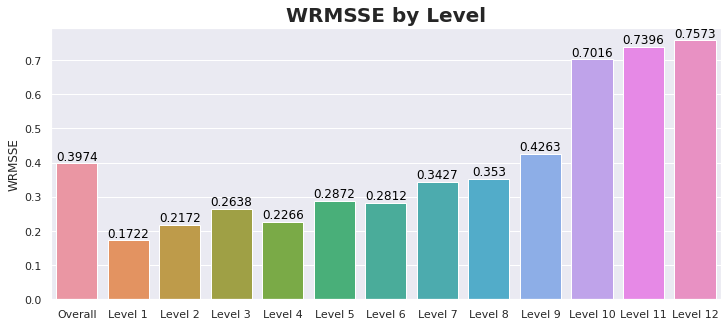

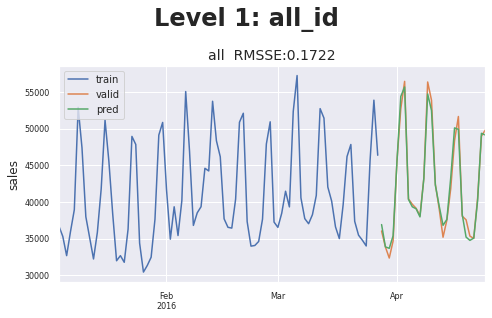

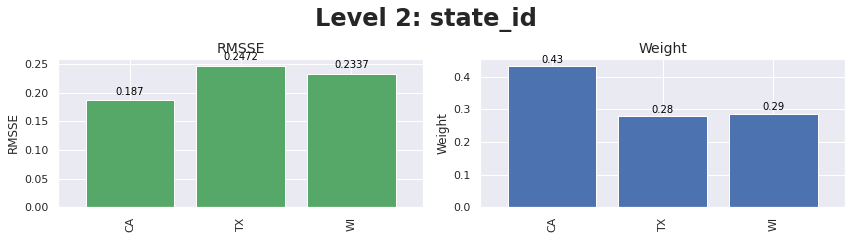

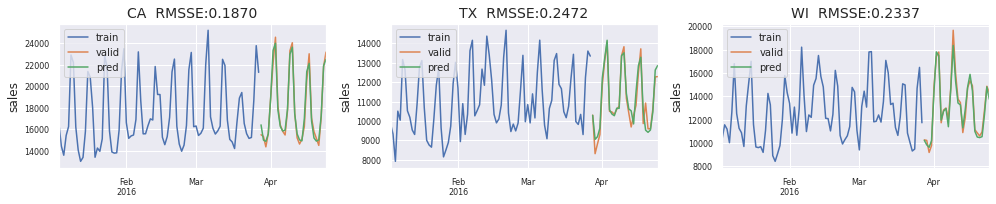

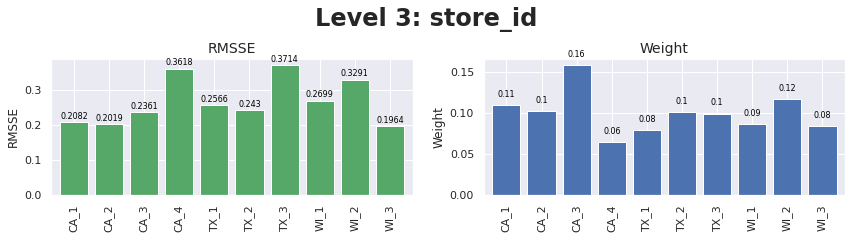

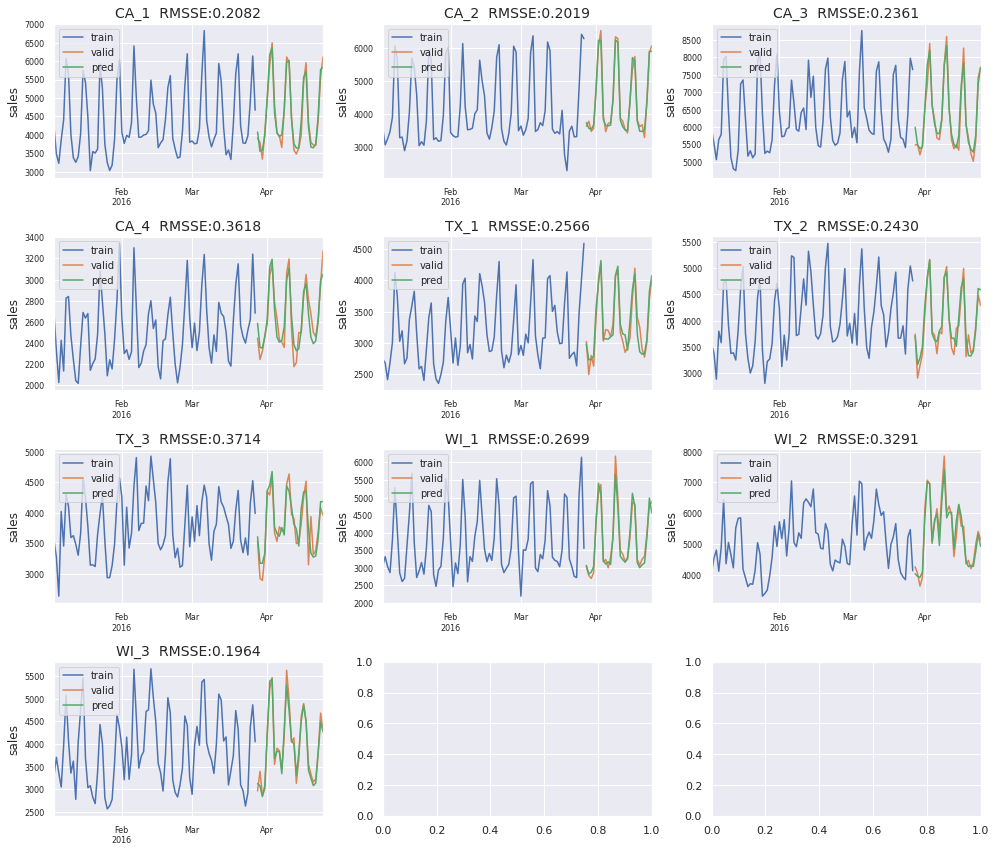

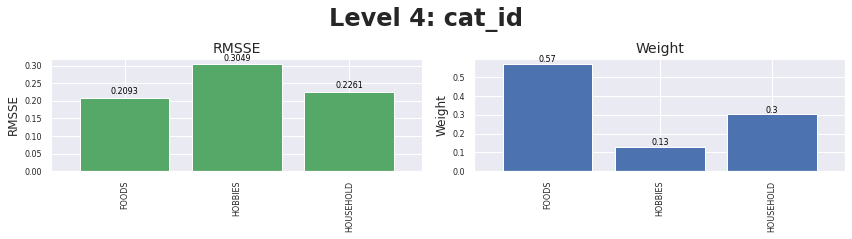

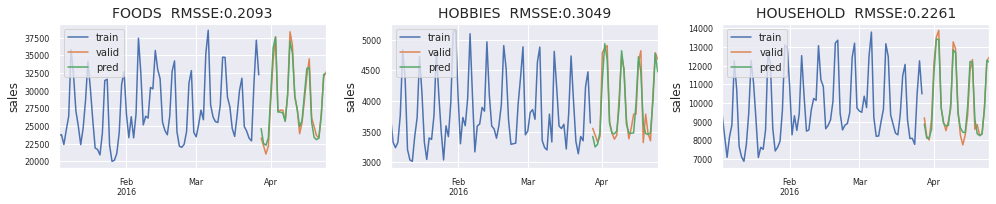

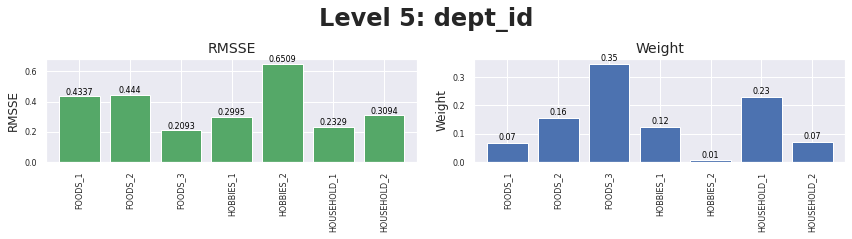

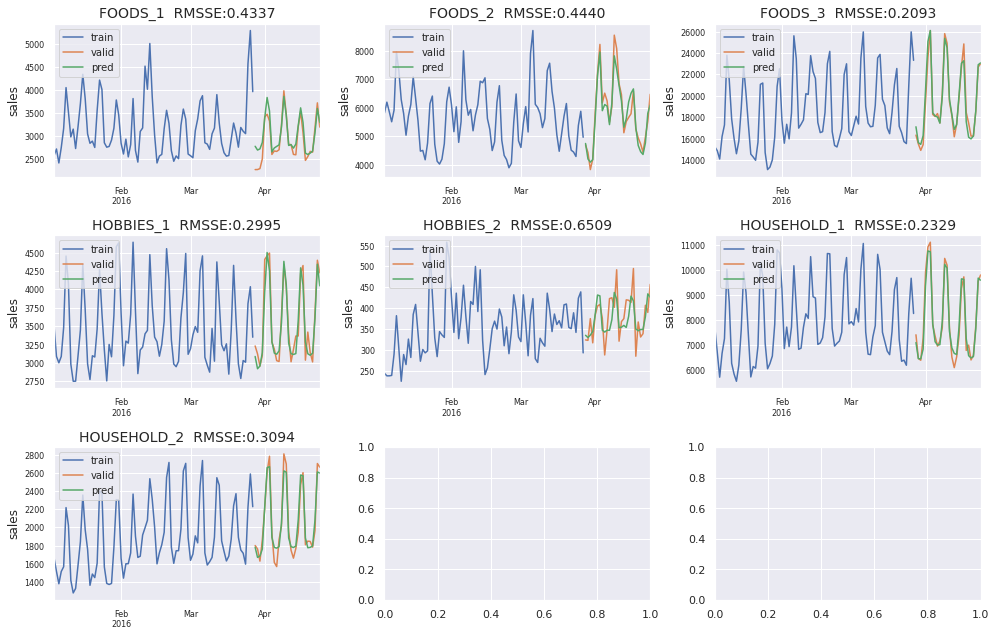

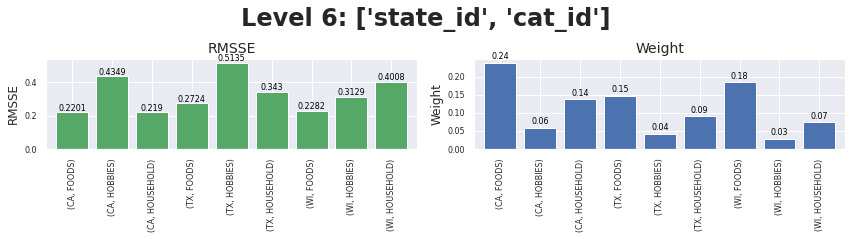

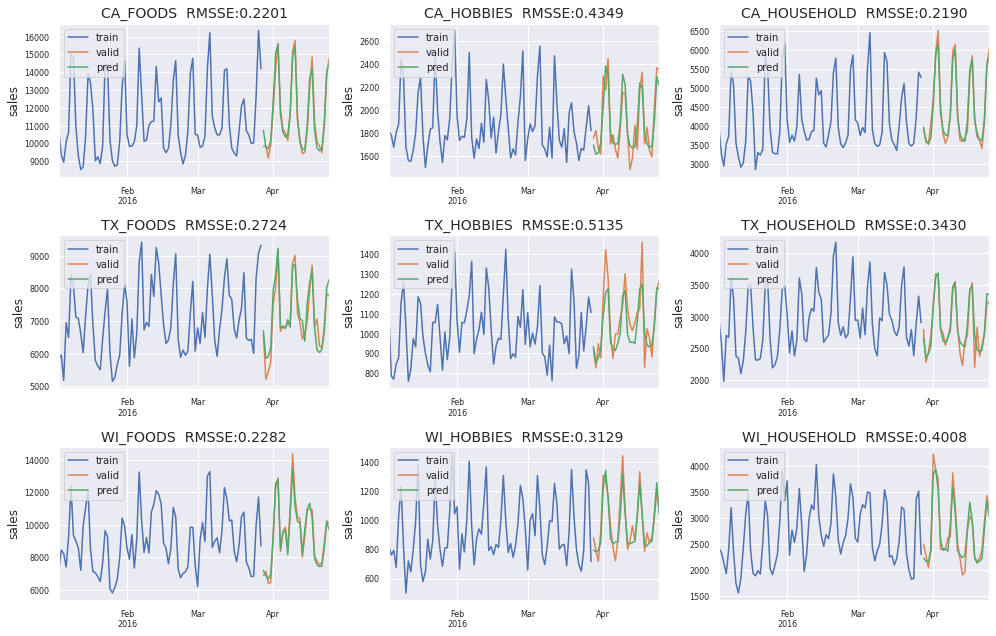

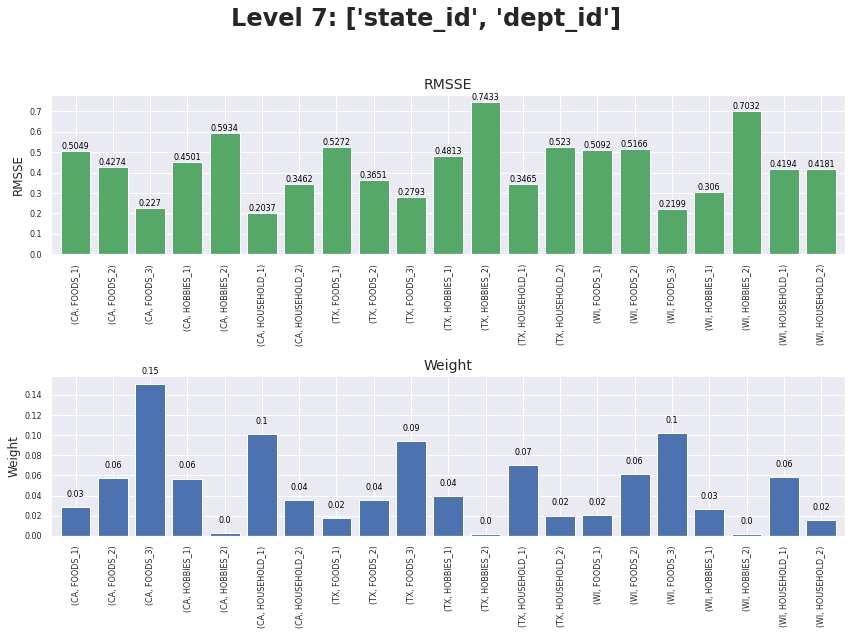

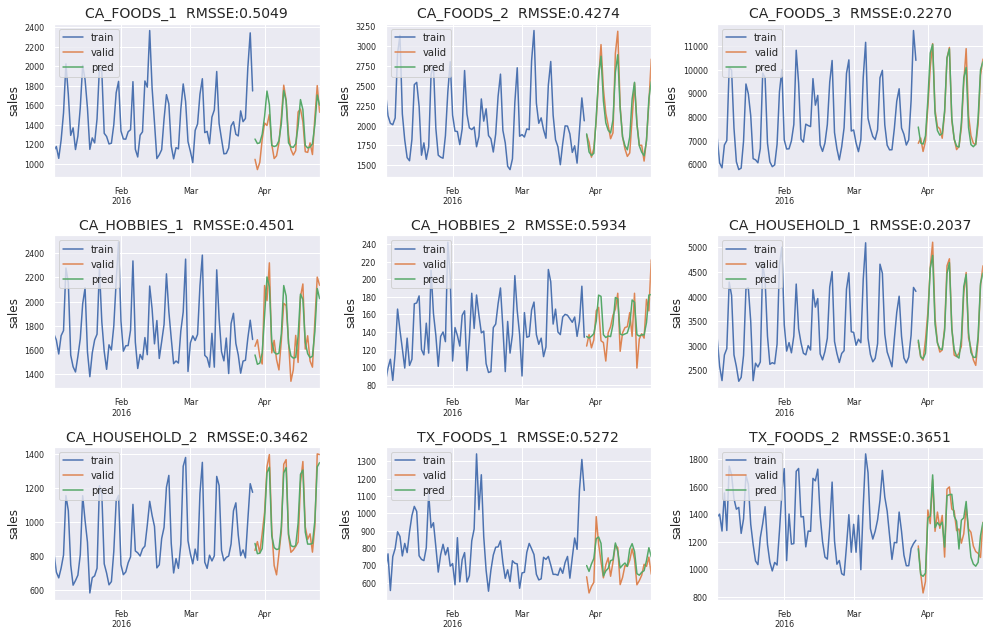

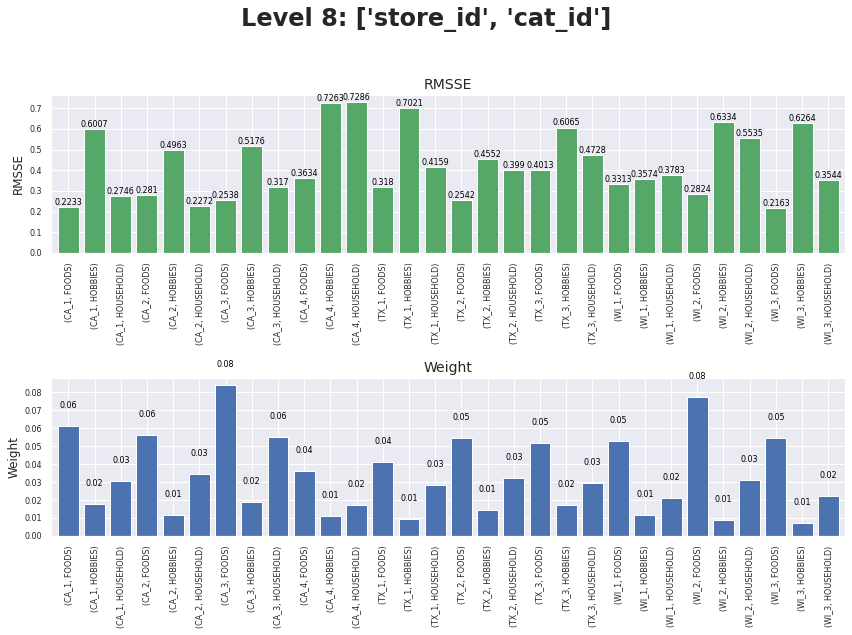

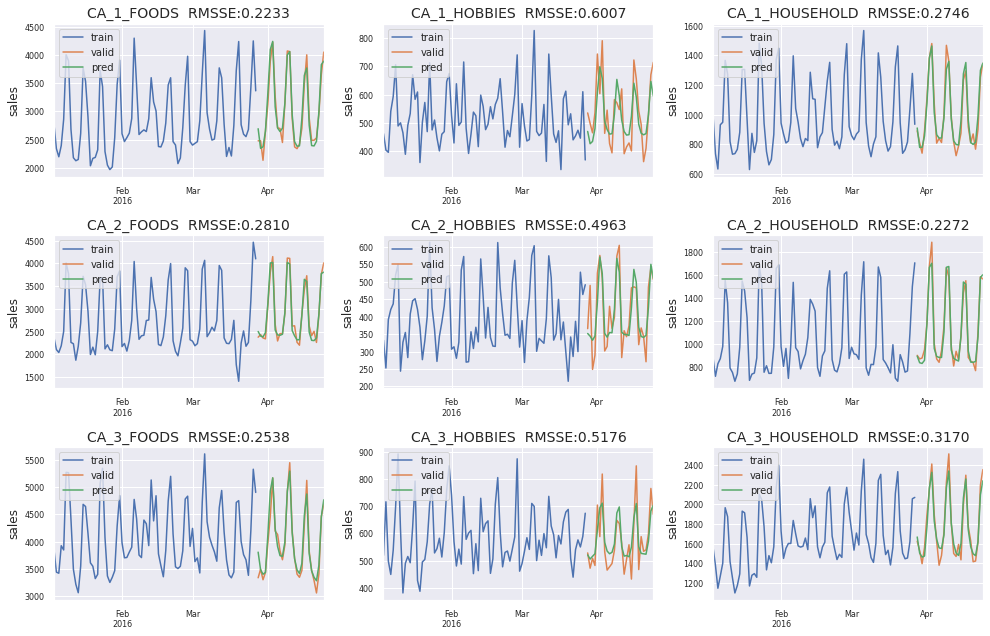

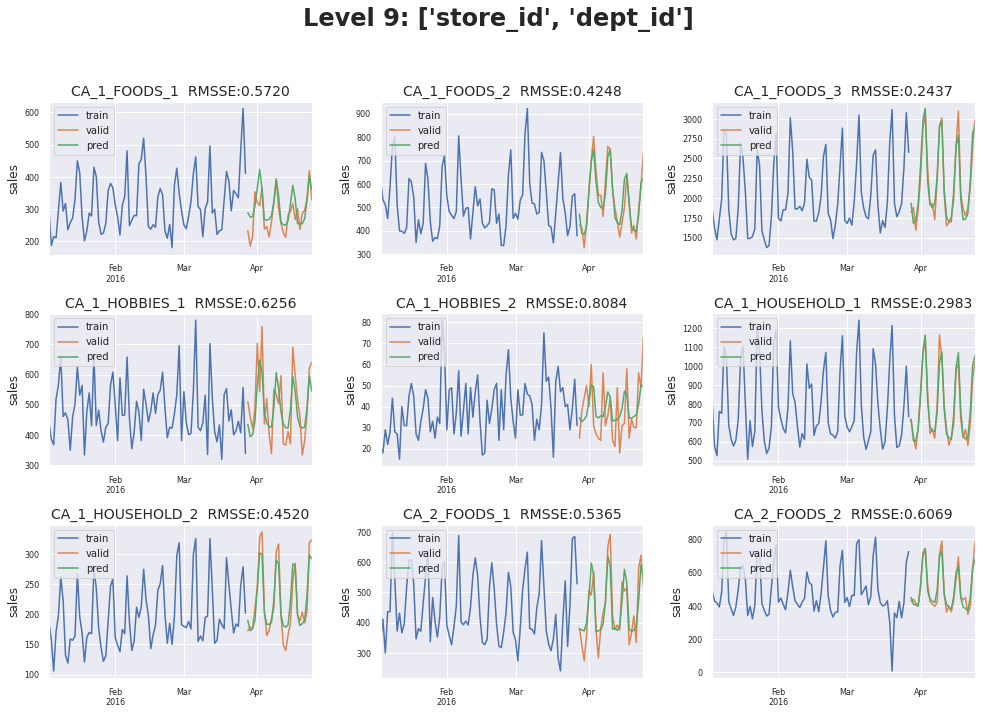

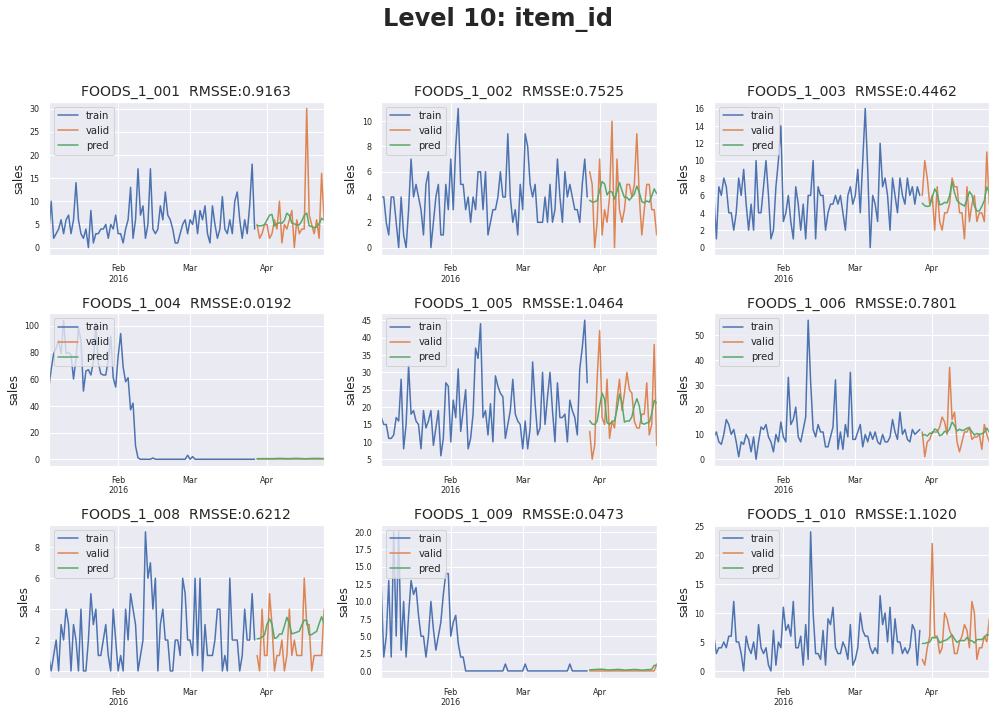

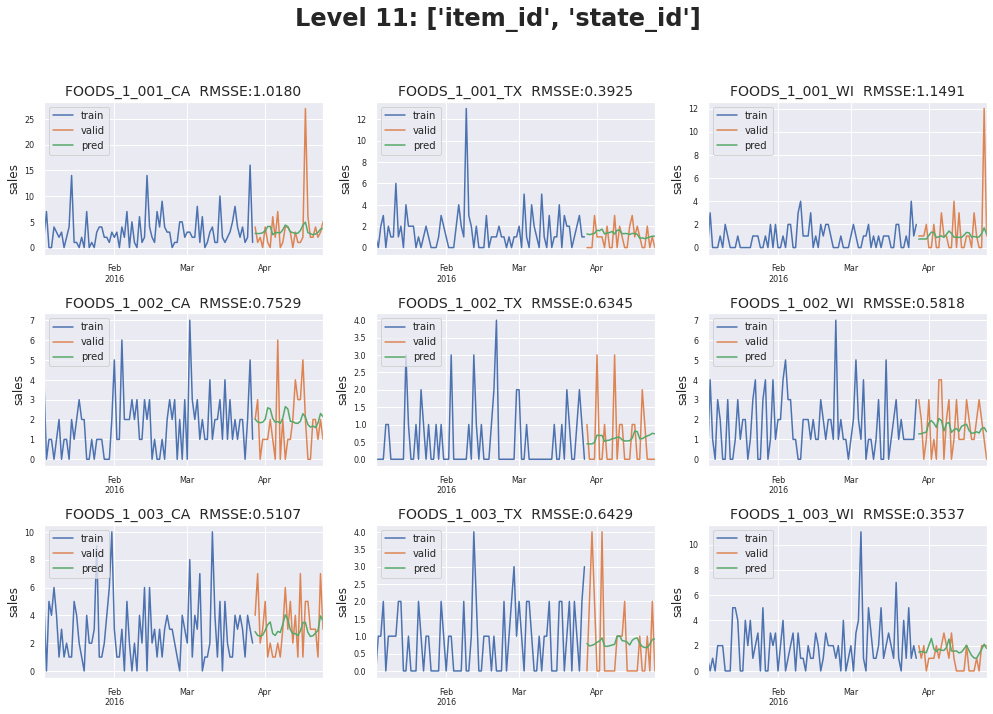

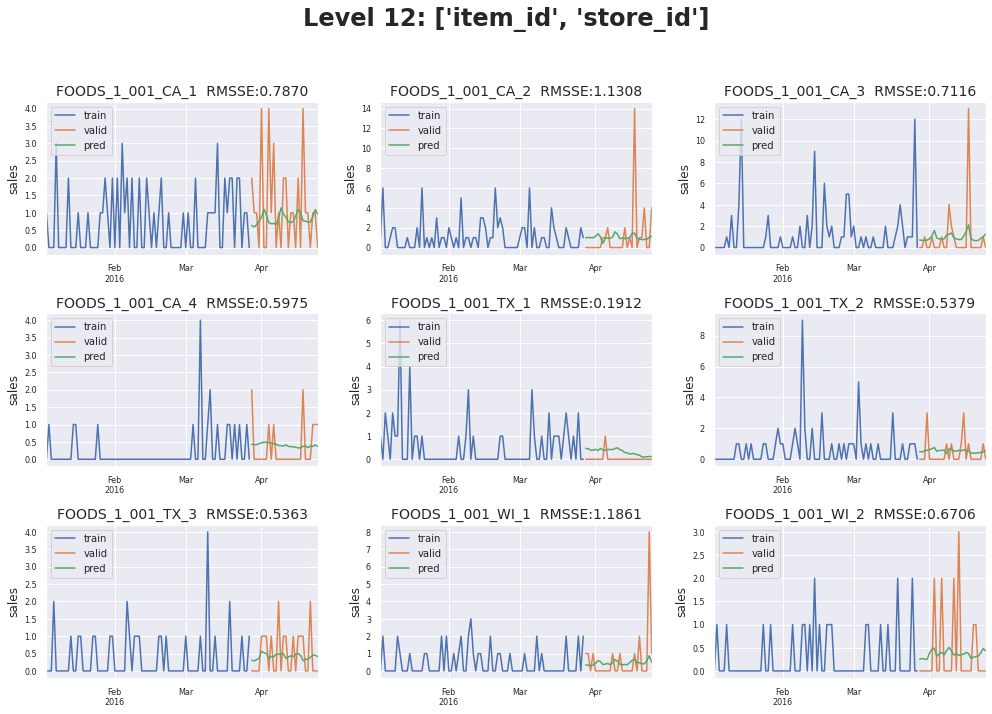

In [22]:
create_dashboard(evaluator)

# Prediction

In [23]:
########################### Predict
#################################################################################

# Create Dummy DataFrame to store predictions
all_preds = pd.DataFrame()

# Join back the Test dataset with 
# a small part of the training data 
# to make recursive features
base_test = get_base_test()

# Timer to measure predictions time 
main_time = time.time()

# Loop over each prediction day
# As rolling lags are the most timeconsuming
# we will calculate it for whole day
for PREDICT_DAY in range(1,29):    
#for PREDICT_DAY in range(1,2):    
 
    print('Predict | Day:', PREDICT_DAY)
    start_time = time.time()

    # Make temporary grid to calculate rolling lags
    grid_df = base_test.copy()
    grid_df = pd.concat([grid_df, df_parallelize_run(make_lag_roll, ROLS_SPLIT)], axis=1)
        
    for store_id in STORES_IDS:
        
        # Read all our models and make predictions
        # for each day/store pairs
        model_path = AUX_MODELS + 'lgb_model_'+store_id+'_v'+str(VER)+'.bin' 
        if USE_AUX:
            model_path = model_path
        
        estimator = pickle.load(open(model_path, 'rb'))
        
        day_mask = base_test['d']==(END_TRAIN+PREDICT_DAY)
        store_mask = base_test['store_id']==store_id
        
        mask = (day_mask)&(store_mask)
        #base_test[TARGET][mask] = estimator.predict(grid_df[mask][MODEL_FEATURES])
        base_test.loc[mask,TARGET]=estimator.predict(grid_df[mask][MODEL_FEATURES])
    # Make good column naming and add 
    # to all_preds DataFrame
    temp_df = base_test[day_mask][['id',TARGET]]
    temp_df.columns = ['id','F'+str(PREDICT_DAY)]
    if 'id' in list(all_preds):
        all_preds = all_preds.merge(temp_df, on=['id'], how='left')
    else:
        all_preds = temp_df.copy()
        
    print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                  ' %0.2f min total |' % ((time.time() - main_time) / 60),
                  ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
    del temp_df
    
all_preds = all_preds.reset_index(drop=True)

Predict | Day: 1
##########  0.67 min round |  0.67 min total |  37805.79 day sales |
Predict | Day: 2
##########  0.66 min round |  1.34 min total |  35063.92 day sales |
Predict | Day: 3
##########  0.66 min round |  2.00 min total |  34494.13 day sales |
Predict | Day: 4
##########  0.66 min round |  2.66 min total |  35029.12 day sales |
Predict | Day: 5
##########  0.67 min round |  3.32 min total |  41450.01 day sales |
Predict | Day: 6
##########  0.66 min round |  3.98 min total |  51738.12 day sales |
Predict | Day: 7
##########  0.66 min round |  4.64 min total |  53369.36 day sales |
Predict | Day: 8
##########  0.66 min round |  5.29 min total |  44422.69 day sales |
Predict | Day: 9
##########  0.66 min round |  5.95 min total |  44187.47 day sales |
Predict | Day: 10
##########  0.66 min round |  6.61 min total |  38779.55 day sales |
Predict | Day: 11
##########  0.66 min round |  7.26 min total |  41006.68 day sales |
Predict | Day: 12
##########  0.66 min round |  7.92

In [0]:
########################### Export
#################################################################################
# Reading competition sample submission and
# merging our predictions
# As we have predictions only for "_validation" data
# we need to do fillna() for "_evaluation" items
submission = pd.read_csv(ORIGINAL+'sample_submission.csv')[['id']]
submission = submission.merge(all_preds, on=['id'], how='left').fillna(0)
#submission.to_csv(AUX_MODELS+'submission_v'+str(VER)+'.csv', index=False)
submission.to_csv('submission_v'+str(VER)+'.csv', index=False)



In [0]:
# Summary

# Of course here is no magic at all.
# No "Novel" features and no brilliant ideas.
# We just carefully joined all
# our previous fe work and created a model.

# Also!
# In my opinion this strategy is a "dead end".
# Overfits a lot LB and with 1 final submission 
# you have no option to risk.


# Improvement should come from:
# Loss function
# Data representation
# Stable CV
# Good features reduction strategy
# Predictions stabilization with NN
# Trend prediction
# Real zero sales detection/classification


# Good kernels references 
## (the order is random and the list is not complete):
# https://www.kaggle.com/ragnar123/simple-lgbm-groupkfold-cv
# https://www.kaggle.com/jpmiller/grouping-items-by-stockout-pattern
# https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda
# https://www.kaggle.com/sibmike/m5-out-of-stock-feature
# https://www.kaggle.com/mayer79/m5-forecast-attack-of-the-data-table
# https://www.kaggle.com/yassinealouini/seq2seq
# https://www.kaggle.com/kailex/m5-forecaster-v2
# https://www.kaggle.com/aerdem4/m5-lofo-importance-on-gpu-via-rapids-xgboost


# Features were created in these kernels:
## 
# Mean encodings and PCA options
# https://www.kaggle.com/kyakovlev/m5-custom-features
##
# Lags and rolling lags
# https://www.kaggle.com/kyakovlev/m5-lags-features
##
# Base Grid and base features (calendar/price/etc)
# https://www.kaggle.com/kyakovlev/m5-simple-fe


# Personal request
# Please don't upvote any ensemble and copypaste kernels
## The worst case is ensemble without any analyse.
## The best choice - just ignore it.
## I would like to see more kernels with interesting and original approaches.
## Don't feed copypasters with upvotes.

## It doesn't mean that you should not fork and improve others kernels
## but I would like to see params and code tuning based on some CV and analyse
## and not only on LB probing.
## Small changes could be shared in comments and authors can improve their kernel.

## Feel free to criticize this kernel as my knowlege is very limited
## and I can be wrong in code and descriptions. 
## Thank you.

In [0]:
imp=pd.DataFrame({'feature': features_columns,

 'importance':estimator.feature_importance()}).sort_values('importance',

 ascending=False)
imp.to_csv(AUX_MODELS+'importance_v'+str(VER)+'.csv', index=False)